In [1]:
import os 
import time
import sys 
sys.path.append("../training")
import pickle
import copy
from itertools import combinations, permutations
import timeit

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from save_data import process_data
from threshold import ThresholdModel

np.random.seed(0)

Helper functions

In [2]:
def split_and_sample_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over sample-axis
    X_I_mean = np.mean(X_I, axis=0)
    X_Q_mean = np.mean(X_Q, axis=0)

    return X_I_mean, X_Q_mean
    
def split_and_time_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over time-axis
    X_I_mean = np.mean(X_I, axis=1)
    X_Q_mean = np.mean(X_Q, axis=1)
    
    return X_I_mean, X_Q_mean

Data

In [3]:
START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0_resplit"

# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

# load data
X = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y = np.load(os.path.join(DATA_DIR, 'y_train.npy'))

# Shorten for convenience
X = X[:10000, :]
y = y[:10000]

Threshold model

In [4]:
from threshold import ThresholdModel

model = ThresholdModel()
model.fit(X,y)
print(f"model.threshold: {model.threshold}")

model.threshold: 285.81903413595535


## 1. Time-averaged I,Q

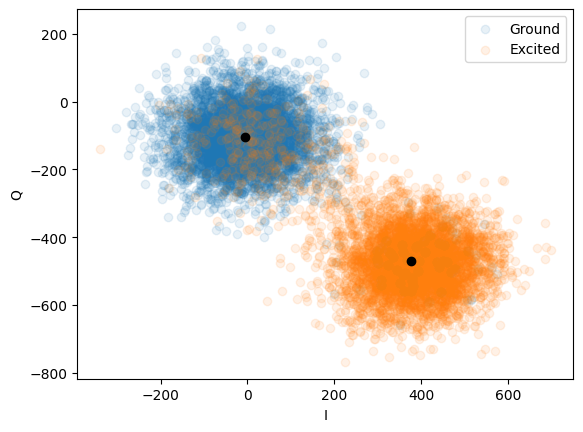

In [5]:
idx0 = np.where(y==0)[0]
idx1 = np.where(y==1)[0]

X0 = X[idx0, :]
X1 = X[idx1, :]

# Split into I and Q timeseries, average over time-axis
X0_I, X0_Q = split_and_time_average(X0)
X1_I, X1_Q = split_and_time_average(X1)

X0_I_median = np.median(X0_I)
X0_Q_median = np.median(X0_Q)
X1_I_median = np.median(X1_I)
X1_Q_median = np.median(X1_Q)

plt.figure()
plt.scatter(X0_I, X0_Q, label = "Ground", alpha = 0.1)
plt.scatter(X1_I, X1_Q, label = "Excited", alpha = 0.1)
plt.scatter(X0_I_median, X0_Q_median, color="black", marker="o")
plt.scatter(X1_I_median, X1_Q_median, color="black", marker="o")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()

## 2. Rotated I,Q

THETA = 0.76


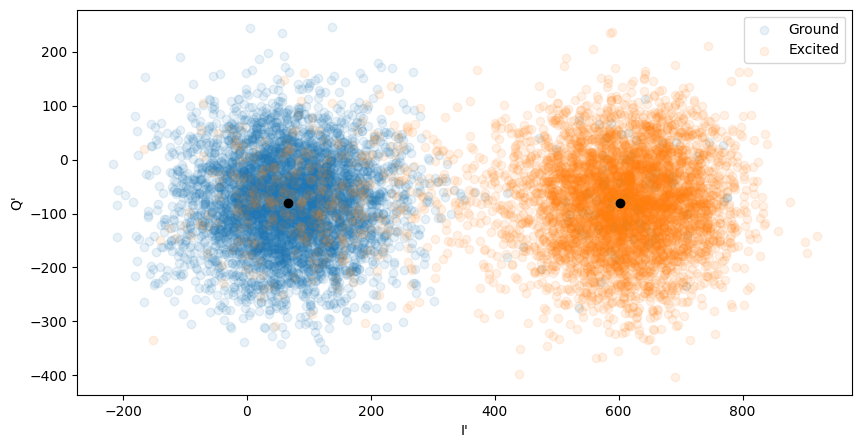

In [6]:
# Compute theta
###################################################################################
THETA = -np.arctan2((X1_Q_median - X0_Q_median), (X1_I_median - X0_I_median))
###################################################################################

print(f"THETA = {THETA:.2f}")

# Rotate IQ clusters by theta
X0_I_prime = X0_I*np.cos(THETA) - X0_Q*np.sin(THETA)
X0_Q_prime = X0_I*np.sin(THETA) + X0_Q*np.cos(THETA)
X1_I_prime = X1_I*np.cos(THETA) - X1_Q*np.sin(THETA)
X1_Q_prime = X1_I*np.sin(THETA) + X1_Q*np.cos(THETA)


X0_I_prime_median = np.median(X0_I_prime)
X0_Q_prime_median = np.median(X0_Q_prime)
X1_I_prime_median = np.median(X1_I_prime)
X1_Q_prime_median = np.median(X1_Q_prime)

plt.figure(figsize = (10,5))
plt.scatter(X0_I_prime, X0_Q_prime, label = "Ground", alpha = 0.1)
plt.scatter(X1_I_prime, X1_Q_prime, label = "Excited", alpha = 0.1)
plt.scatter(X0_I_prime_median, X0_Q_prime_median, color="black", marker="o")
plt.scatter(X1_I_prime_median, X1_Q_prime_median, color="black", marker="o")
plt.xlabel("I'")
plt.ylabel("Q'")
plt.legend()

## 3. Probability densities/histograms 

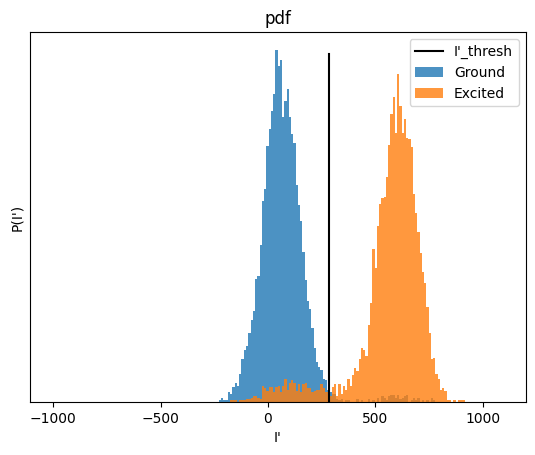

In [13]:
nbins = 200
xlims = [-1000, 1100]
hist_0, bin_edges_0 = np.histogram(X0_I_prime, bins = nbins, range = xlims)
hist_1, bin_edges_1 = np.histogram(X1_I_prime, bins = nbins, range = xlims)

plt.figure()
plt.bar(bin_edges_0[:hist_0.shape[0]], hist_0, label = "Ground", width = 10.5, alpha = 0.8)
plt.bar(bin_edges_1[:hist_1.shape[0]], hist_1, label = "Excited", width = 10.5, alpha = 0.8)
plt.plot(model.threshold*np.ones(1000), np.linspace(0, 260, 1000), label = "I'_thresh", color = "black")
plt.xlabel("I'")
plt.ylabel("P(I')")
plt.yticks([], [])
plt.title("pdf")
plt.legend()
plt.show()

## 4. Cumulative distribution functions (np.cumsum(histogram))

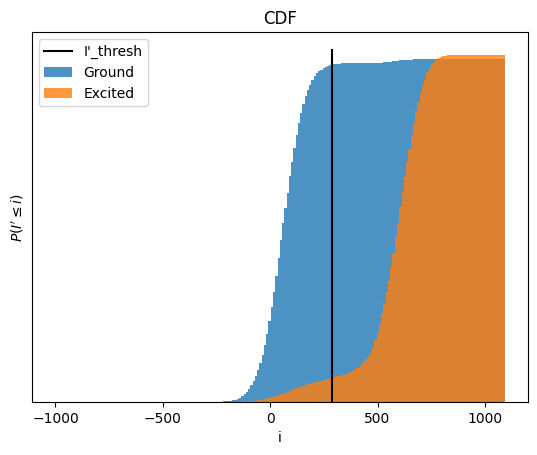

In [23]:
# Compute CDFs (np.cumsum(histogram))
CDF_0 = np.cumsum(hist_0)
CDF_1 = np.cumsum(hist_1)

plt.figure()
plt.bar(bin_edges_0[:hist_0.shape[0]], CDF_0, label = "Ground", width = 10.5, alpha = 0.8)
plt.bar(bin_edges_1[:hist_1.shape[0]], CDF_1, label = "Excited", width = 10.5, alpha = 0.8)
plt.plot(model.threshold*np.ones(1000), np.linspace(0, 5100, 1000), label = "I'_thresh", color = "black")
plt.xlabel("i")
plt.ylabel(r"$P(I' \leq i)$")
plt.yticks([], [])
plt.title("CDF")
plt.legend()
plt.show()

## 5. Contrast

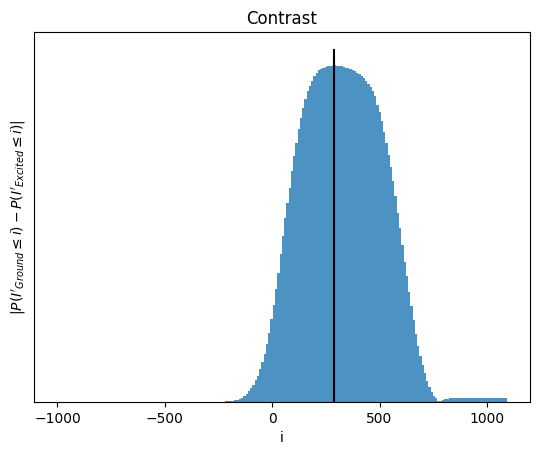

In [24]:
norm_factor = 1/(0.5*hist_0.sum() + 0.5*hist_1.sum())
contrast = np.abs(norm_factor*(CDF_0 - CDF_1))

plt.figure()
plt.bar(bin_edges_0[:hist_0.shape[0]], np.abs(contrast), width = 10.5, alpha = 0.8)
plt.plot(model.threshold*np.ones(1000), np.linspace(0, 0.95, 1000), label = "I'_thresh", color = "black")
plt.xlabel("i")
plt.ylabel(r"$| P(I'_{Ground} \leq i) - P(I'_{Excited} \leq i) |$")
plt.title("Contrast")
plt.yticks([], [])
plt.show()

## 6. Threshold, all in one shot

In [58]:
# Compute theta
X0_I_median = np.median(X0_I)
X0_Q_median = np.median(X0_Q)
X1_I_median = np.median(X1_I)
X1_Q_median = np.median(X1_Q)

###################################################################################
theta = -np.arctan2((X1_Q_median - X0_Q_median), (X1_I_median - X0_I_median))
###################################################################################

# Rotate IQ clusters by theta
X0_I_prime = X0_I*np.cos(theta) - X0_Q*np.sin(theta)
X0_Q_prime = X0_I*np.sin(theta) + X0_Q*np.cos(theta)
X1_I_prime = X1_I*np.cos(theta) - X1_Q*np.sin(theta)
X1_Q_prime = X1_I*np.sin(theta) + X1_Q*np.cos(theta)

# Compute probability densities (histograms)
hist_0, bin_edges_0 = np.histogram(X0_I_prime, bins = nbins, range = [-1000, 1100])
hist_1, bin_edges_1 = np.histogram(X1_I_prime, bins = nbins, range = [-1000, 1100])

# Compute CDFs (np.cumsum(histogram))
CDF_0 = np.cumsum(hist_0)
CDF_1 = np.cumsum(hist_1)

# Compute difference between CDFs
contrast_unsigned_unnormed = np.abs(CDF_0 - CDF_1)
normalization = 1/(0.5*hist_0.sum() + 0.5*hist_1.sum())
contrast_unsigned = normalization*contrast_unsigned_unnormed
contrast = np.abs(contrast_unsigned)


threshold_idx = np.argmax(contrast)
threshold = bin_edges_0[threshold_idx]
print(f"threshold = {threshold}")

threshold = 291.5


In [59]:
from threshold import ThresholdModel

model = ThresholdModel()
model.fit(X,y)
print(f"model.threshold: {model.threshold}")

model.threshold: 285.81903413595535


## 7. One more plot

In [ ]:
X0_I_prime = X0_I*np.cos(THETA) - X0_Q*np.sin(THETA)
X0_Q_prime = X0_I*np.sin(THETA) + X0_Q*np.cos(THETA)
X1_I_prime = X1_I*np.cos(THETA) - X1_Q*np.sin(THETA)
X1_Q_prime = X1_I*np.sin(THETA) + X1_Q*np.cos(THETA)


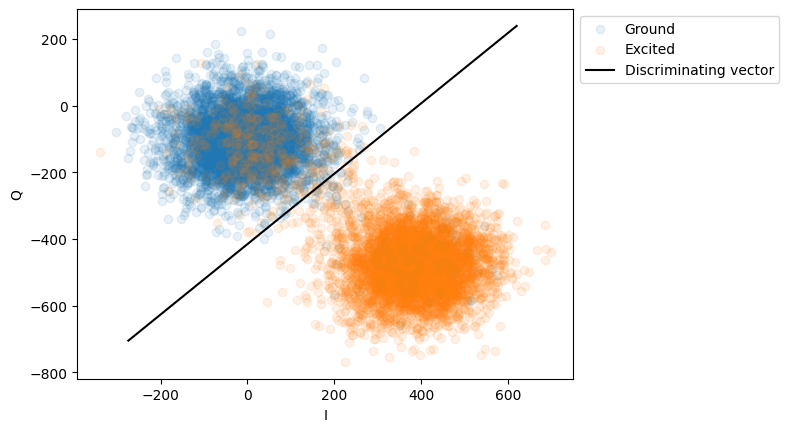

In [25]:
plt.figure()

plt.scatter(X0_I, X0_Q, alpha = 0.1, label = "Ground")
plt.scatter(X1_I, X1_Q, alpha = 0.1, label = "Excited")

x_thresh = model.threshold*np.ones(1000)
y_thresh = np.linspace(-700, 600, 1000)

x_thresh_prime = x_thresh*np.cos(-model.theta) - y_thresh*np.sin(-model.theta)
y_thresh_prime = x_thresh*np.sin(-model.theta) + y_thresh*np.cos(-model.theta)
plt.plot(x_thresh_prime, y_thresh_prime, label = "Discriminating vector", color = "black")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend(bbox_to_anchor = (1,1))
plt.show()